In [4]:
#import

import sys
import os
import pandas
import torch
import numpy as np

import Bonn_dataset.F as f_data

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import torch.nn as nn
import torch.nn.functional as functional
from torch.utils.data import DataLoader
import torchvision


#params

training_batch = 100
learning_rate = 0.001
batch_size = 100
max_epochs = 15

params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}

freq = 173.61

#files, get raw data, define labels

directory_F = '/Users/kimgunhee/workspace/BonnEEG/Bonn_dataset/F'
directory_N = '/Users/kimgunhee/workspace/BonnEEG/Bonn_dataset/N'
directory_O = '/Users/kimgunhee/workspace/BonnEEG/Bonn_dataset/O'
directory_S = '/Users/kimgunhee/workspace/BonnEEG/Bonn_dataset/S'
directory_Z = '/Users/kimgunhee/workspace/BonnEEG/Bonn_dataset/Z'

fileList_F = os.listdir(directory_F)
fileList_N = os.listdir(directory_N)
fileList_O = os.listdir(directory_O)
fileList_S = os.listdir(directory_S)
fileList_Z = os.listdir(directory_Z)


rawdata_F = list([])
for f in fileList_F :
    temp_arr = []
    r = open(directory_F +'/'+ f, mode = 'r')
    for lines in r.readlines():
        temp_arr.append(lines.splitlines()[0])
    rawdata_F.append(np.array(temp_arr, dtype='double'))

print(len(rawdata_F))
print(rawdata_F[0])
print(np.shape(rawdata_F[0]))

rawdata_N = list([])
for f in fileList_N :
    temp_arr = []
    r = open(directory_N +'/'+ f, mode = 'r')
    for lines in r.readlines():
        temp_arr.append(lines.splitlines()[0])
    rawdata_N.append(np.array(temp_arr, dtype='double'))

rawdata_O = list([])
for f in fileList_O :
    temp_arr = []
    r = open(directory_O +'/'+ f, mode = 'r')
    for lines in r.readlines():
        temp_arr.append(lines.splitlines()[0])
    rawdata_O.append(np.array(temp_arr, dtype='double'))

rawdata_S = list([])
for f in fileList_S :
    temp_arr = []
    r = open(directory_S +'/'+ f, mode = 'r')
    for lines in r.readlines():
        temp_arr.append(lines.splitlines()[0])
    rawdata_S.append(np.array(temp_arr, dtype='double'))

rawdata_Z = list([])
for f in fileList_Z :
    temp_arr = []
    r = open(directory_Z +'/'+ f, mode = 'r')
    for lines in r.readlines():
        temp_arr.append(lines.splitlines()[0])
    rawdata_Z.append(np.array(temp_arr, dtype='double'))


labels_F = [[0,0,1]]*100
labels_N = [[0,0,1]]*100
labels_O = [[0,1,0]]*100
labels_S = [[1,0,0]]*100
labels_Z = [[0,1,0]]*100

total_raw_data = list([])
total_raw_data += rawdata_F
print(np.shape(rawdata_F[0]))
print(np.shape(total_raw_data[0][0]))
total_raw_data+=rawdata_N
total_raw_data+=rawdata_O
total_raw_data+=rawdata_S
total_raw_data+=rawdata_Z
print(len(total_raw_data))

total_labels = list([])
total_labels += labels_F
total_labels+=labels_N
print('f :', len(labels_F))
print(len(total_labels))
total_labels+=labels_O
total_labels+=labels_S
total_labels+=labels_Z
print(len(total_labels))
total_labels = np.array(total_labels)


100
[-29. -40. -44. ...  23.  15. -41.]
(4097,)
(4097,)
()
500
f : 100
200
500


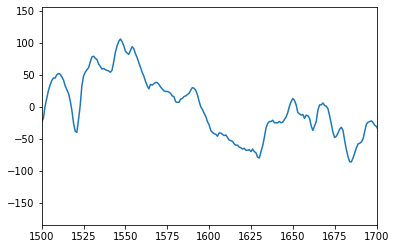

In [5]:
# plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(rawdata_F[0])
plt.rcParams["figure.figsize"] = (20, 3)
plt.xlim(1500, 1700)
plt.show()


In [6]:
#class Dataset(X, y)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, labels):
        'Initialization'
        self.dataset = dataset
        self.labels = labels

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dataset)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = np.array([self.dataset[index]], dtype = 'double')
        y = self.labels[index]

        return X, y

# training, test set
import numpy as np

total_index = np.arange(0, 499)
np.random.shuffle(total_index)
test_index = total_index[:100]
training_index = total_index[100:]

training_raw_data = list([])
training_labels = list([])
test_raw_data = list([])
test_labels = list([])

for i in training_index :
    training_raw_data.append(total_raw_data[i])
    training_labels.append(total_labels[i])

for i in test_index :
    test_raw_data.append(total_raw_data[i])
    test_labels.append(total_labels[i])

print(training_labels)
print(test_labels)


# generator

transform = torchvision.transforms.ToTensor()
training_set = Dataset(training_raw_data, training_labels)
training_generator = torch.utils.data.DataLoader(training_set, **params)
test_set = Dataset(test_raw_data, test_labels)
test_generator = torch.utils.data.DataLoader(test_set, **params)


class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv1d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv1d(32, 64, 3, 1)
        self.dropout1 = torch.nn.Dropout(0.25)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(130944, 128)
        self.fc2 = torch.nn.Linear(128, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = functional.relu(x)
        x = self.conv2(x)
        x = functional.relu(x)

        x = functional.max_pool1d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        output = functional.log_softmax(x, dim=1)
        return output


[array([0, 1, 0]), array([0, 0, 1]), array([0, 0, 1]), array([0, 1, 0]), array([1, 0, 0]), array([0, 1, 0]), array([0, 1, 0]), array([0, 1, 0]), array([1, 0, 0]), array([1, 0, 0]), array([0, 0, 1]), array([0, 0, 1]), array([0, 0, 1]), array([0, 0, 1]), array([0, 0, 1]), array([0, 1, 0]), array([0, 0, 1]), array([0, 0, 1]), array([0, 1, 0]), array([0, 1, 0]), array([0, 0, 1]), array([0, 1, 0]), array([0, 0, 1]), array([0, 0, 1]), array([1, 0, 0]), array([0, 1, 0]), array([0, 1, 0]), array([0, 0, 1]), array([0, 1, 0]), array([1, 0, 0]), array([0, 1, 0]), array([0, 1, 0]), array([1, 0, 0]), array([0, 0, 1]), array([0, 1, 0]), array([0, 1, 0]), array([0, 0, 1]), array([1, 0, 0]), array([1, 0, 0]), array([1, 0, 0]), array([0, 0, 1]), array([0, 1, 0]), array([1, 0, 0]), array([0, 0, 1]), array([1, 0, 0]), array([0, 0, 1]), array([0, 1, 0]), array([0, 1, 0]), array([0, 0, 1]), array([0, 0, 1]), array([0, 0, 1]), array([0, 0, 1]), array([0, 0, 1]), array([0, 1, 0]), array([0, 1, 0]), array([0,

In [8]:
#training

device = 'cpu'
model = CNN().double()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


for epoch in range(max_epochs):
    avg_loss = 0
    step = 0

    for inputs, labels in training_generator:

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels,1)[1])
        loss.backward()
        optimizer.step()

        avg_loss += loss/400

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_loss))

#test

avg_loss_test = 0
test_batch = len(test_generator)
total = 0
correct = 0

with torch.no_grad() :

    for inputs, labels in test_generator:

        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs_test = model(inputs)

        labels_max = torch.max(labels,1)[1]
        loss_test = criterion(outputs_test, torch.max(labels,1)[1])
        avg_loss_test += loss_test/100

        _, predicted = torch.max(outputs_test.data, 1)
        for label, prediction in zip(labels_max, predicted) :
            if label == prediction :
                correct += 1
                print('correct label, prediction :', label)
            else :
                print('correct label, prediction :', label, prediction)
            total += 1

accuracy = 0
if total != 0 :
    accuracy = correct / total

print('accuracy : ', accuracy)
print('avg_loss_test : ', avg_loss_test)

[Epoch:    1] cost = 20.88391
[Epoch:    2] cost = 5.61256366
[Epoch:    3] cost = 2.06640301
[Epoch:    4] cost = 0.491402991
[Epoch:    5] cost = 0.188582593
[Epoch:    6] cost = 0.106841796
[Epoch:    7] cost = 0.0479079994
[Epoch:    8] cost = 0.0126971088
[Epoch:    9] cost = 0.00761827697
[Epoch:   10] cost = 0.00339828614
[Epoch:   11] cost = 0.0025383487
[Epoch:   12] cost = 0.00109149423
[Epoch:   13] cost = 0.000689093905
[Epoch:   14] cost = 0.000671199932
[Epoch:   15] cost = 0.000369850847
correct label, prediction : tensor(2)
correct label, prediction : tensor(0)
correct label, prediction : tensor(2)
correct label, prediction : tensor(1)
correct label, prediction : tensor(0) tensor(1)
correct label, prediction : tensor(1)
correct label, prediction : tensor(0) tensor(1)
correct label, prediction : tensor(0) tensor(1)
correct label, prediction : tensor(1)
correct label, prediction : tensor(1)
correct label, prediction : tensor(1)
correct label, prediction : tensor(0) tensor

In [68]:
prac = list([0, 0, 0, 1])
print(prac)
print(np.array(prac))
np_sample = np.array([0, 0, 1])
print(np_sample)
nptorch = torch.from_numpy(np_sample)
print(type(nptorch))
print(nptorch)
print(torch.tensor(np.argmax(prac, axis = 0)))

[0, 0, 0, 1]
[0 0 0 1]
[0 0 1]
<class 'torch.Tensor'>
tensor([0, 0, 1])
tensor(3)
